## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up data (eBOSS P1D measurement from Chabanier et al. 2019)

In [2]:
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.7,zmax=3.3)

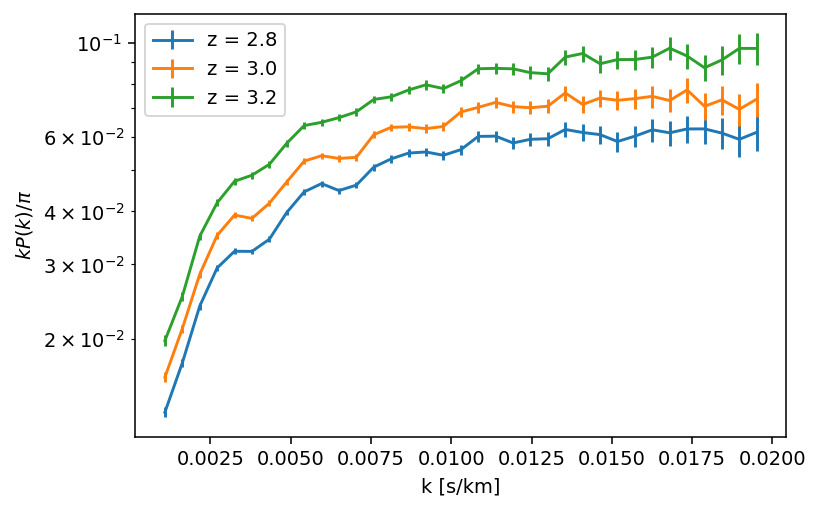

In [3]:
data.plot_p1d()

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [4]:
emulator_label="LaCE-NN"
if emulator_label=="LaCE-GP":
    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif emulator_label=="LaCE-NN":
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Setup a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [5]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [6]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,
                            emulator=emulator,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

will not store truth, working with real data


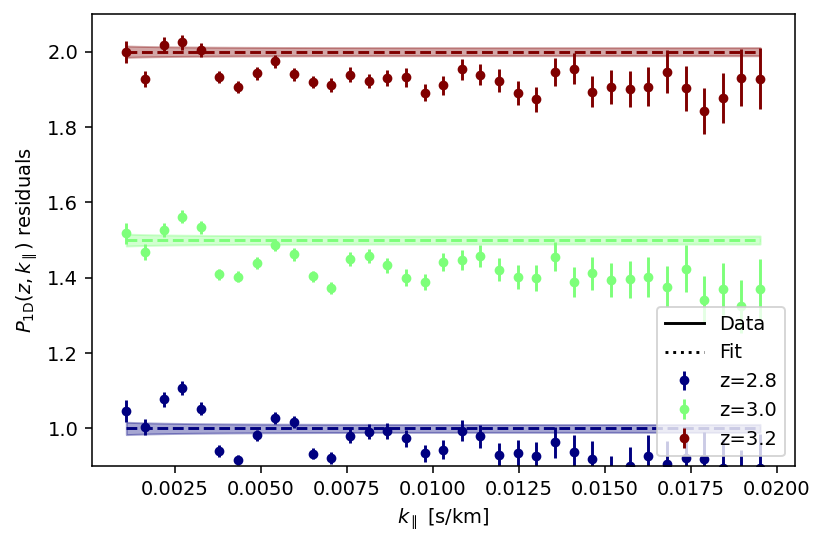

In [18]:
like.plot_p1d(residuals=True,plot_every_iz=1)

# Try iminuit minimizer

In [8]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 671.5303107871044


In [9]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [10]:
minimizer.minimize(compute_hesse=True)

In [11]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 671.5303107871044 to 398.40734936058215


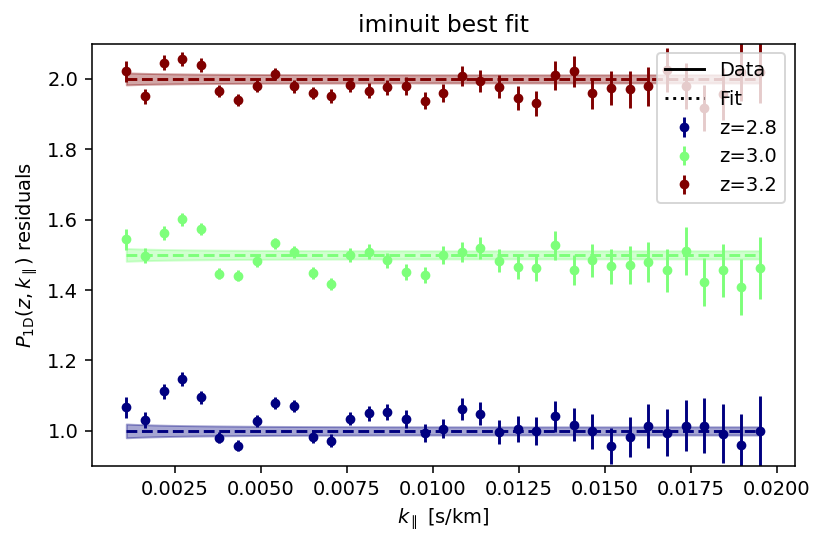

In [19]:
minimizer.plot_best_fit(plot_every_iz=1)

In [13]:
if free_cosmo:
    minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [14]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 157.5                      │             Nfcn = 1635              │
│ EDM = 1.25e+99 (Goal: 0.0001)    │           time = 27.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │620.620e-3 │ 0.017e-3  │            │            │         │         │       │
│ 1 │ x1   │588.776e-3 │ 0.029e-3  │            │            │         │         │       │
│ 2 │ x2   │ 999.95e-3 │  0.05e-3  │            │            │         │         │       │
│ 3 │ x3   │290.614716875546776009286986663937568664550781250000e-6│0.000000000000000000000000000000000000000000000014e-6│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        x0        x1        x2        x3 │
├────┼─────────────────────────────────────────┤
│ x0 │  2.89e-10  1.12e-10  2.41e-10 3.65e-110 │
│ x1 │  1.12e-10  8.64e-10  1.22e-09 2.87e-109 │
│ x2 │  2.41e-10  1.22e-09  2.06e-09 4.36e-109 │
│ x3 │ 3.65e-110 2.87e-109 4.36e-109 1.92e-106 │
└────┴─────────────────────────────────────────┘

In [15]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [16]:
#minimizer.minimizer.draw_mnprofile("x0")

In [17]:
a=3